In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchxrayvision as xrv
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc


def load_image_list(file_path):
    with open(file_path, 'r') as f:
        return set(line.strip() for line in f)


train_val_image_set = load_image_list('train_val_list.txt')
test_image_set = load_image_list('test_list.txt')


dataset = xrv.datasets.NIH_Dataset(
    imgpath='images/', 
    csvpath='dataset/Data_Entry_2017.csv',
    unique_patients=False,
    views=['PA', 'AP'],
)

transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512),
])
dataset.transform = transform

In [ ]:
def filter_dataset_by_image_list(dataset, image_set):
    filtered_idxs = [i for i in range(len(dataset)) if os.path.basename(dataset.csv.iloc[i]["Image Index"]) in image_set]
    return xrv.datasets.SubsetDataset(dataset, filtered_idxs)


train_val_dataset = filter_dataset_by_image_list(dataset, train_val_image_set)
test_dataset = filter_dataset_by_image_list(dataset, test_image_set)


print(f"Training/Validation dataset size: {len(train_val_dataset)}")

df_train = train_val_dataset.csv 
patients = df_train['Patient ID'].unique()

train_patients, val_patients = train_test_split(
    patients, test_size=0.15, random_state=42
)

train_indices = [
    idx for idx in range(len(train_val_dataset))
    if df_train.iloc[idx]['Patient ID'] in train_patients
]
val_indices = [
    idx for idx in range(len(train_val_dataset))
    if df_train.iloc[idx]['Patient ID'] in val_patients
]

train_dataset = Subset(train_val_dataset, train_indices)
val_dataset = Subset(train_val_dataset, val_indices)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training/Validation dataset size: 86524
Training dataset size: 73916
Validation dataset size: 12608
Testing dataset size: 25596


In [3]:
batch_size = 32
num_workers = 64
pin_memory = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = xrv.models.ResNet(weights="resnet50-res512-all")
model.op_threshs = None
model.model.fc = torch.nn.Linear(model.model.fc.in_features, 14)
model = model.to(device)

optimizer = torch.optim.Adam(model.model.fc.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

In [5]:
thresholds = torch.tensor(
    [0.039117552, 0.0034529066, 0.11396341, 0.0057298196, 0.00045666535, 0.0018880932,
     0.012037827, 0.038744126, 0.0037213727, 0.014730946, 0.016149804, 0.054241467,
     0.037198864, 0.0004403434], 
    device=device
)

# The class names needs to correspond to the thresholds defined
class_names = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
val_precisions = []
val_recalls = []
val_f1s = []
auc_scores = []

train_class_accuracies = [[] for _ in range(len(class_names))]
val_class_accuracies = [[] for _ in range(len(class_names))]

num_epochs = 40


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    train_correct_per_class = [0] * len(class_names)
    train_total_per_class = [0] * len(class_names)

    # Train on the training dataset
    for batch in train_loader:
        images = batch["img"].to(device)
        labels = batch["lab"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (probabilities > thresholds).float()
        correct += (preds == labels).sum().item()
        total += labels.numel()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        for i in range(len(class_names)):
            train_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            train_total_per_class[i] += (labels[:, i] == 1).sum().item()

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    train_epoch_class_accuracies = [
        correct / total if total > 0 else 0
        for correct, total in zip(train_correct_per_class, train_total_per_class)
    ]
    for i in range(len(class_names)):
        train_class_accuracies[i].append(train_epoch_class_accuracies[i])

    # Validate on the validation dataset
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_preds_val = []
    all_labels = []
    val_correct_per_class = [0] * len(class_names)
    val_total_per_class = [0] * len(class_names)

    with torch.no_grad():
        for batch in val_loader:
            images = batch["img"].to(device)
            labels = batch["lab"].to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            preds = (probabilities > thresholds).float()
            correct += (preds == labels).sum().item()
            total += labels.numel()

            all_preds.append(preds.cpu())
            all_preds_val.append(probabilities.cpu())
            all_labels.append(labels.cpu())

            for i in range(len(class_names)):
                val_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
                val_total_per_class[i] += (labels[:, i] == 1).sum().item()

    all_preds = torch.cat(all_preds).numpy()
    all_preds_val = torch.cat(all_preds_val).numpy()
    all_labels = torch.cat(all_labels).numpy()

    for i, class_name in enumerate(class_names):
        auc = roc_auc_score(all_labels[:, i], all_preds_val[:, i])
        auc_scores.append(auc)
        print(f"{class_name} - AUC: {auc:.4f}")

    class_report = classification_report(
        all_labels, all_preds, target_names=class_names, zero_division=0)
    print("Validation Classification Report:\n", class_report)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    val_epoch_class_accuracies = [
        correct / total if total > 0 else 0
        for correct, total in zip(val_correct_per_class, val_total_per_class)
    ]
    for i in range(len(class_names)):
        val_class_accuracies[i].append(val_epoch_class_accuracies[i])

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, ")

    print("\nTrain Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {train_class_accuracies[i][-1]:.4f}")
    
    print("\nValidation Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {val_class_accuracies[i][-1]:.4f}")


Atelectasis - AUC: 0.6516
Consolidation - AUC: 0.6297
Infiltration - AUC: 0.6501
Pneumothorax - AUC: 0.7864
Edema - AUC: 0.7348
Emphysema - AUC: 0.4920
Fibrosis - AUC: 0.4159
Effusion - AUC: 0.5684
Pneumonia - AUC: 0.6097
Pleural_Thickening - AUC: 0.4320
Cardiomegaly - AUC: 0.4304
Nodule - AUC: 0.4469
Mass - AUC: 0.5782
Hernia - AUC: 0.4686
Validation Classification Report:
                     precision    recall  f1-score   support

       Atelectasis       0.10      1.00      0.19      1277
     Consolidation       0.02      1.00      0.04       254
      Infiltration       0.06      0.05      0.05       370
      Pneumothorax       0.01      1.00      0.03       177
             Edema       0.10      1.00      0.18      1244
         Emphysema       0.01      1.00      0.02       149
          Fibrosis       0.02      0.98      0.03       200
          Effusion       0.00      0.36      0.00        28
         Pneumonia       0.15      1.00      0.27      1929
Pleural_Thickening   

In [ ]:
# Testing the trained model
model.eval() 

test_loss = 0
correct = 0
total = 0
test_preds = []
test_probs = []
test_labels = []
test_correct_per_class = [0] * len(class_names)
test_total_per_class = [0] * len(class_names)

with torch.no_grad():
    for batch in test_loader:  
        images = batch["img"].to(device)
        labels = batch["lab"].to(device)

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()

        preds = (probabilities > thresholds).float() 
        correct += (preds == labels).sum().item()
        total += labels.numel()

        test_preds.append(preds.cpu())
        test_probs.append(probabilities.cpu())
        test_labels.append(labels.cpu())

        for i in range(len(class_names)):
            test_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            test_total_per_class[i] += (labels[:, i] == 1).sum().item()

test_preds = torch.cat(test_preds).numpy()
test_probs = torch.cat(test_probs).numpy()
test_labels = torch.cat(test_labels).numpy()

test_accuracy = correct / total
test_loss = test_loss / len(test_loader)

test_class_accuracies = [
    correct / total if total > 0 else 0
    for correct, total in zip(test_correct_per_class, test_total_per_class)
]

for i, class_name in enumerate(class_names):
    auc_score = roc_auc_score(test_labels[:, i], test_probs[:, i])
    print(f"{class_name} - AUC: {auc_score:.4f}")


test_class_report = classification_report(
    test_labels, test_preds, target_names=class_names, zero_division=0)
print("\nTest Classification Report:\n", test_class_report)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("\nTest Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {test_class_accuracies[i]:.4f}")

Atelectasis - AUC: 0.7587
Consolidation - AUC: 0.8867
Infiltration - AUC: 0.7394
Pneumothorax - AUC: 0.8491
Edema - AUC: 0.8230
Emphysema - AUC: 0.8870
Fibrosis - AUC: 0.8245
Effusion - AUC: 0.9325
Pneumonia - AUC: 0.7062
Pleural_Thickening - AUC: 0.8088
Cardiomegaly - AUC: 0.7583
Nodule - AUC: 0.7527
Mass - AUC: 0.7126
Hernia - AUC: 0.8748

Test Classification Report:
                     precision    recall  f1-score   support

       Atelectasis       0.16      0.95      0.27      3279
     Consolidation       0.05      0.99      0.10      1069
      Infiltration       0.16      0.42      0.23      1815
      Pneumothorax       0.05      0.98      0.10       925
             Edema       0.18      1.00      0.31      4658
         Emphysema       0.05      1.00      0.09      1093
          Fibrosis       0.04      0.80      0.08       435
          Effusion       0.80      0.23      0.36        86
         Pneumonia       0.24      1.00      0.39      6112
Pleural_Thickening       0

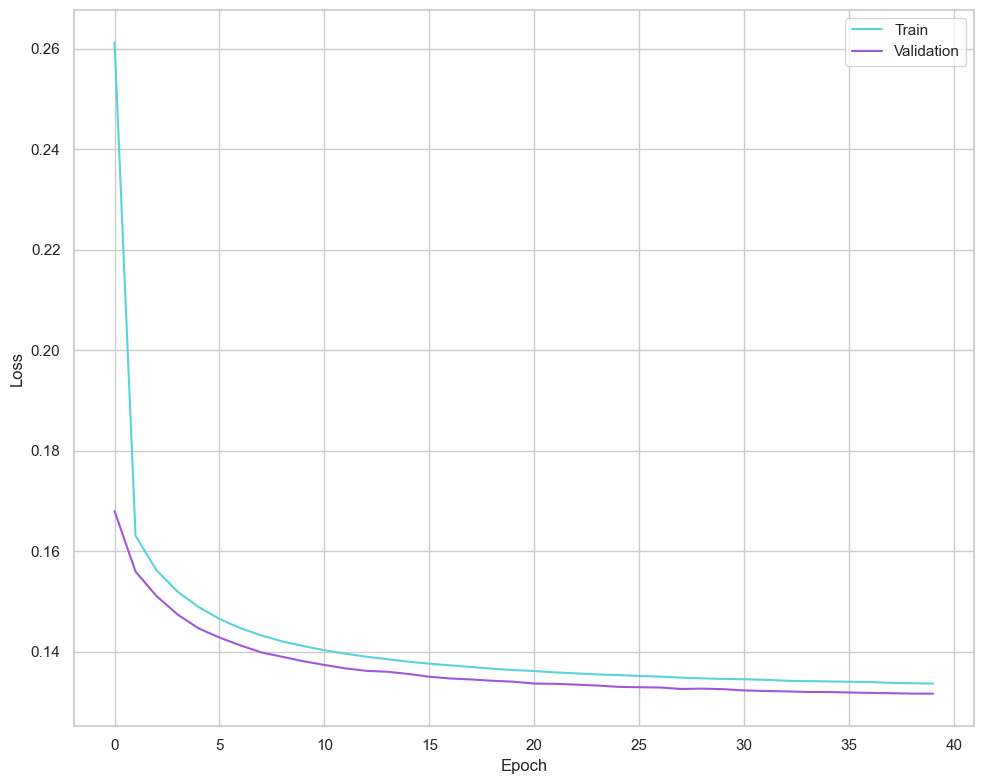

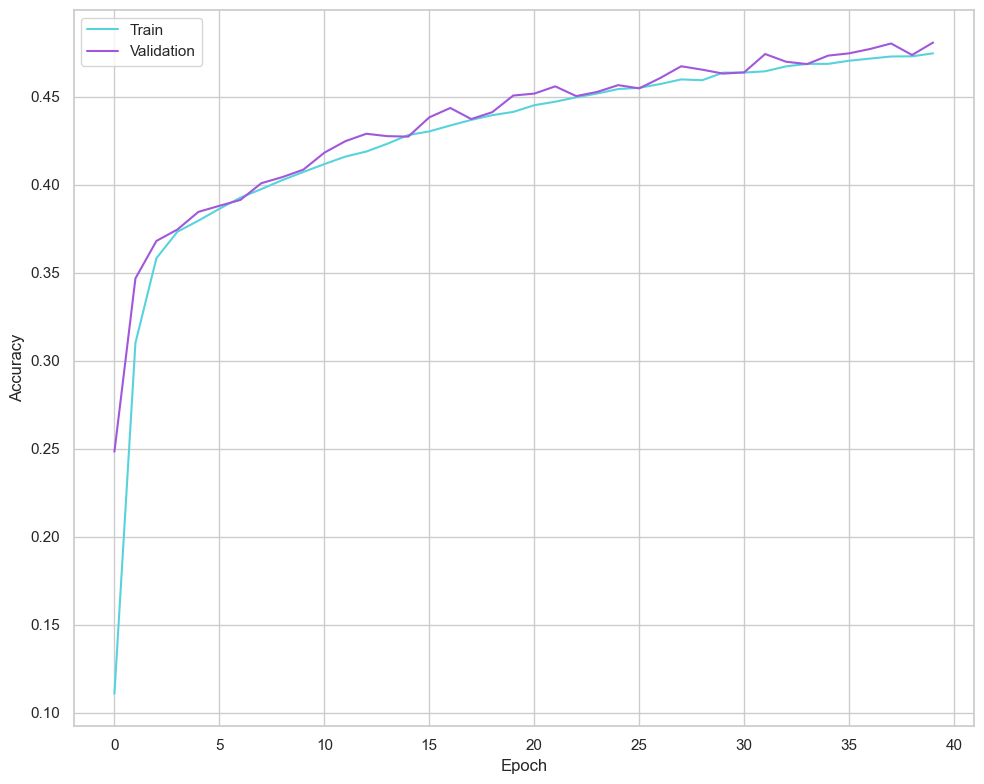

In [8]:
palette = sns.color_palette("hls", 4)

# Plot Loss
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(num_epochs), y=train_losses, label='Train', color=palette[2])
sns.lineplot(x=range(num_epochs), y=val_losses, label='Validation', color=palette[3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_resnet50.png')
plt.show()

# Plot Accuracy
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(num_epochs), y=train_accuracies, label='Train', color=palette[2])
sns.lineplot(x=range(num_epochs), y=val_accuracies, label='Validation', color=palette[3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('accuracy_resnet50.png')
plt.show()

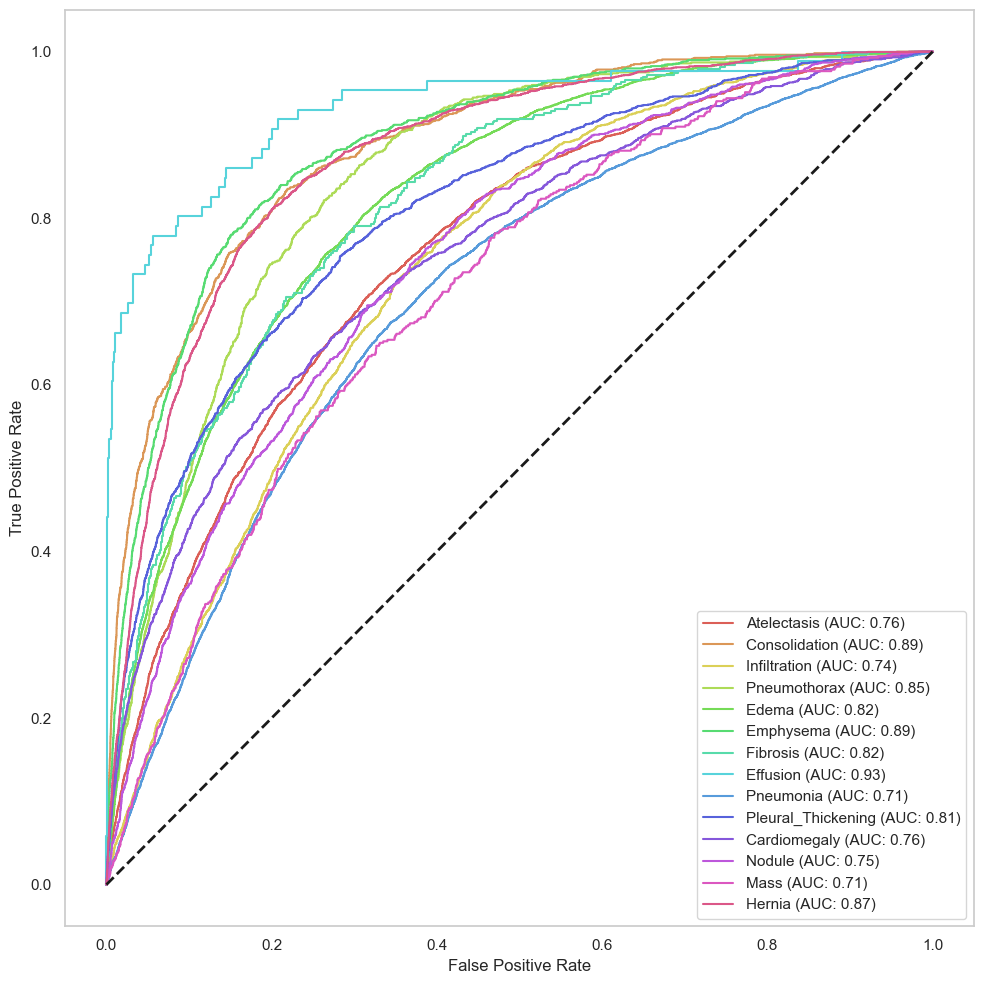

In [ ]:
# Plot AUROC
palette = sns.color_palette("hls", len(class_names))
plt.figure(figsize=(10, 10))

for i, (class_name, color) in enumerate(zip(class_names, palette)):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{class_name} (AUC: {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig('auc_resnet50.png')
plt.show()